In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE 
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier

In [2]:
from sklearn.metrics import classification_report

def report(model, x, y, text = "trening"):
    y_pred = model.predict(x)
    
    print(f'Klasifikacioni izveštaj za model {type(model).__name__} za {text} podatke')
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")
    
    print(f'Matrica konfuzije za model {type(model).__name__}za {text} podatke')
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['0', '1', '-1'], index=['0', '1', '-1']))
    print("---------------------------------------------------------------------------------")
    


In [3]:
X_train = pd.read_csv("../preprocessing/X_train.csv")
y_train = pd.read_csv("../preprocessing/y_train.csv")
X_test = pd.read_csv("../preprocessing/X_test.csv")
y_test = pd.read_csv("../preprocessing/y_test.csv")

In [4]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [5]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

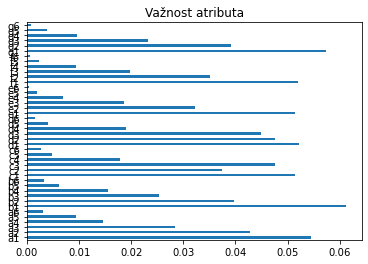

In [6]:
pd.Series(clf.feature_importances_, index=X_train.columns).plot.barh()
plt.title("Važnost atributa")
plt.show()

Iz značajnosti stributa vidimo da je mnogo bitnije da li su i kako popunjena polja u dnu table, nego na vrhu, što i ima smisla s obzirom na to kako se igra igra.

In [7]:
report(clf, X_train, y_train)

Klasifikacioni izveštaj za model DecisionTreeClassifier za trening podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.98      0.97      0.97     35597
           0       0.97      0.98      0.97     35597
           1       1.00      1.00      1.00     35597

    accuracy                           0.98    106791
   macro avg       0.98      0.98      0.98    106791
weighted avg       0.98      0.98      0.98    106791

---------------------------------------------------------------------------------
Matrica konfuzije za model DecisionTreeClassifierza trening podatke
---------------------------------------------------------------------------------
        0      1     -1
0   34434   1163      0
1     711  34886      0
-1      0      0  35597
---------------------------------------------------------------------------------


In [8]:
report(clf, X_test, y_test, "test")

Klasifikacioni izveštaj za model DecisionTreeClassifier za test podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.63      0.70      0.66      3341
           0       0.24      0.34      0.28      1295
           1       0.88      0.79      0.83      8876

    accuracy                           0.72     13512
   macro avg       0.58      0.61      0.59     13512
weighted avg       0.76      0.72      0.74     13512

---------------------------------------------------------------------------------
Matrica konfuzije za model DecisionTreeClassifierza test podatke
---------------------------------------------------------------------------------
       0    1    -1
0   2344  454   543
1    441  440   414
-1   947  961  6968
---------------------------------------------------------------------------------


Vidimo da je preciznost modela na trening podacima 1, ali da je ne test podacima mnogo manja. Dakle možemo pokušati da podesimo hiperparametre.

In [9]:
parameters = {'max_depth' : [2, 4, 6, 8],
             'criterion' : ['gini', 'entropy']}
estimator = GridSearchCV(tree.DecisionTreeClassifier(), param_grid=parameters, cv=3)
estimator.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8]})

In [10]:
estimator.best_params_

{'criterion': 'gini', 'max_depth': 8}

In [11]:
estimator.best_score_

0.576659081757826

In [12]:
report(estimator.best_estimator_, X_train, y_train)

Klasifikacioni izveštaj za model DecisionTreeClassifier za trening podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.62      0.50      0.55     35597
           0       0.53      0.66      0.59     35597
           1       0.67      0.65      0.66     35597

    accuracy                           0.60    106791
   macro avg       0.61      0.60      0.60    106791
weighted avg       0.61      0.60      0.60    106791

---------------------------------------------------------------------------------
Matrica konfuzije za model DecisionTreeClassifierza trening podatke
---------------------------------------------------------------------------------
        0      1     -1
0   17630  12685   5282
1    6034  23347   6216
-1   4592   7880  23125
---------------------------------------------------------------------------------


In [13]:
report(estimator.best_estimator_, X_test, y_test, "test")

Klasifikacioni izveštaj za model DecisionTreeClassifier za test podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.54      0.50      0.52      3341
           0       0.19      0.57      0.28      1295
           1       0.87      0.64      0.73      8876

    accuracy                           0.60     13512
   macro avg       0.53      0.57      0.51     13512
weighted avg       0.72      0.60      0.64     13512

---------------------------------------------------------------------------------
Matrica konfuzije za model DecisionTreeClassifierza test podatke
---------------------------------------------------------------------------------
       0     1    -1
0   1680  1099   562
1    263   734   298
-1  1158  2068  5650
---------------------------------------------------------------------------------


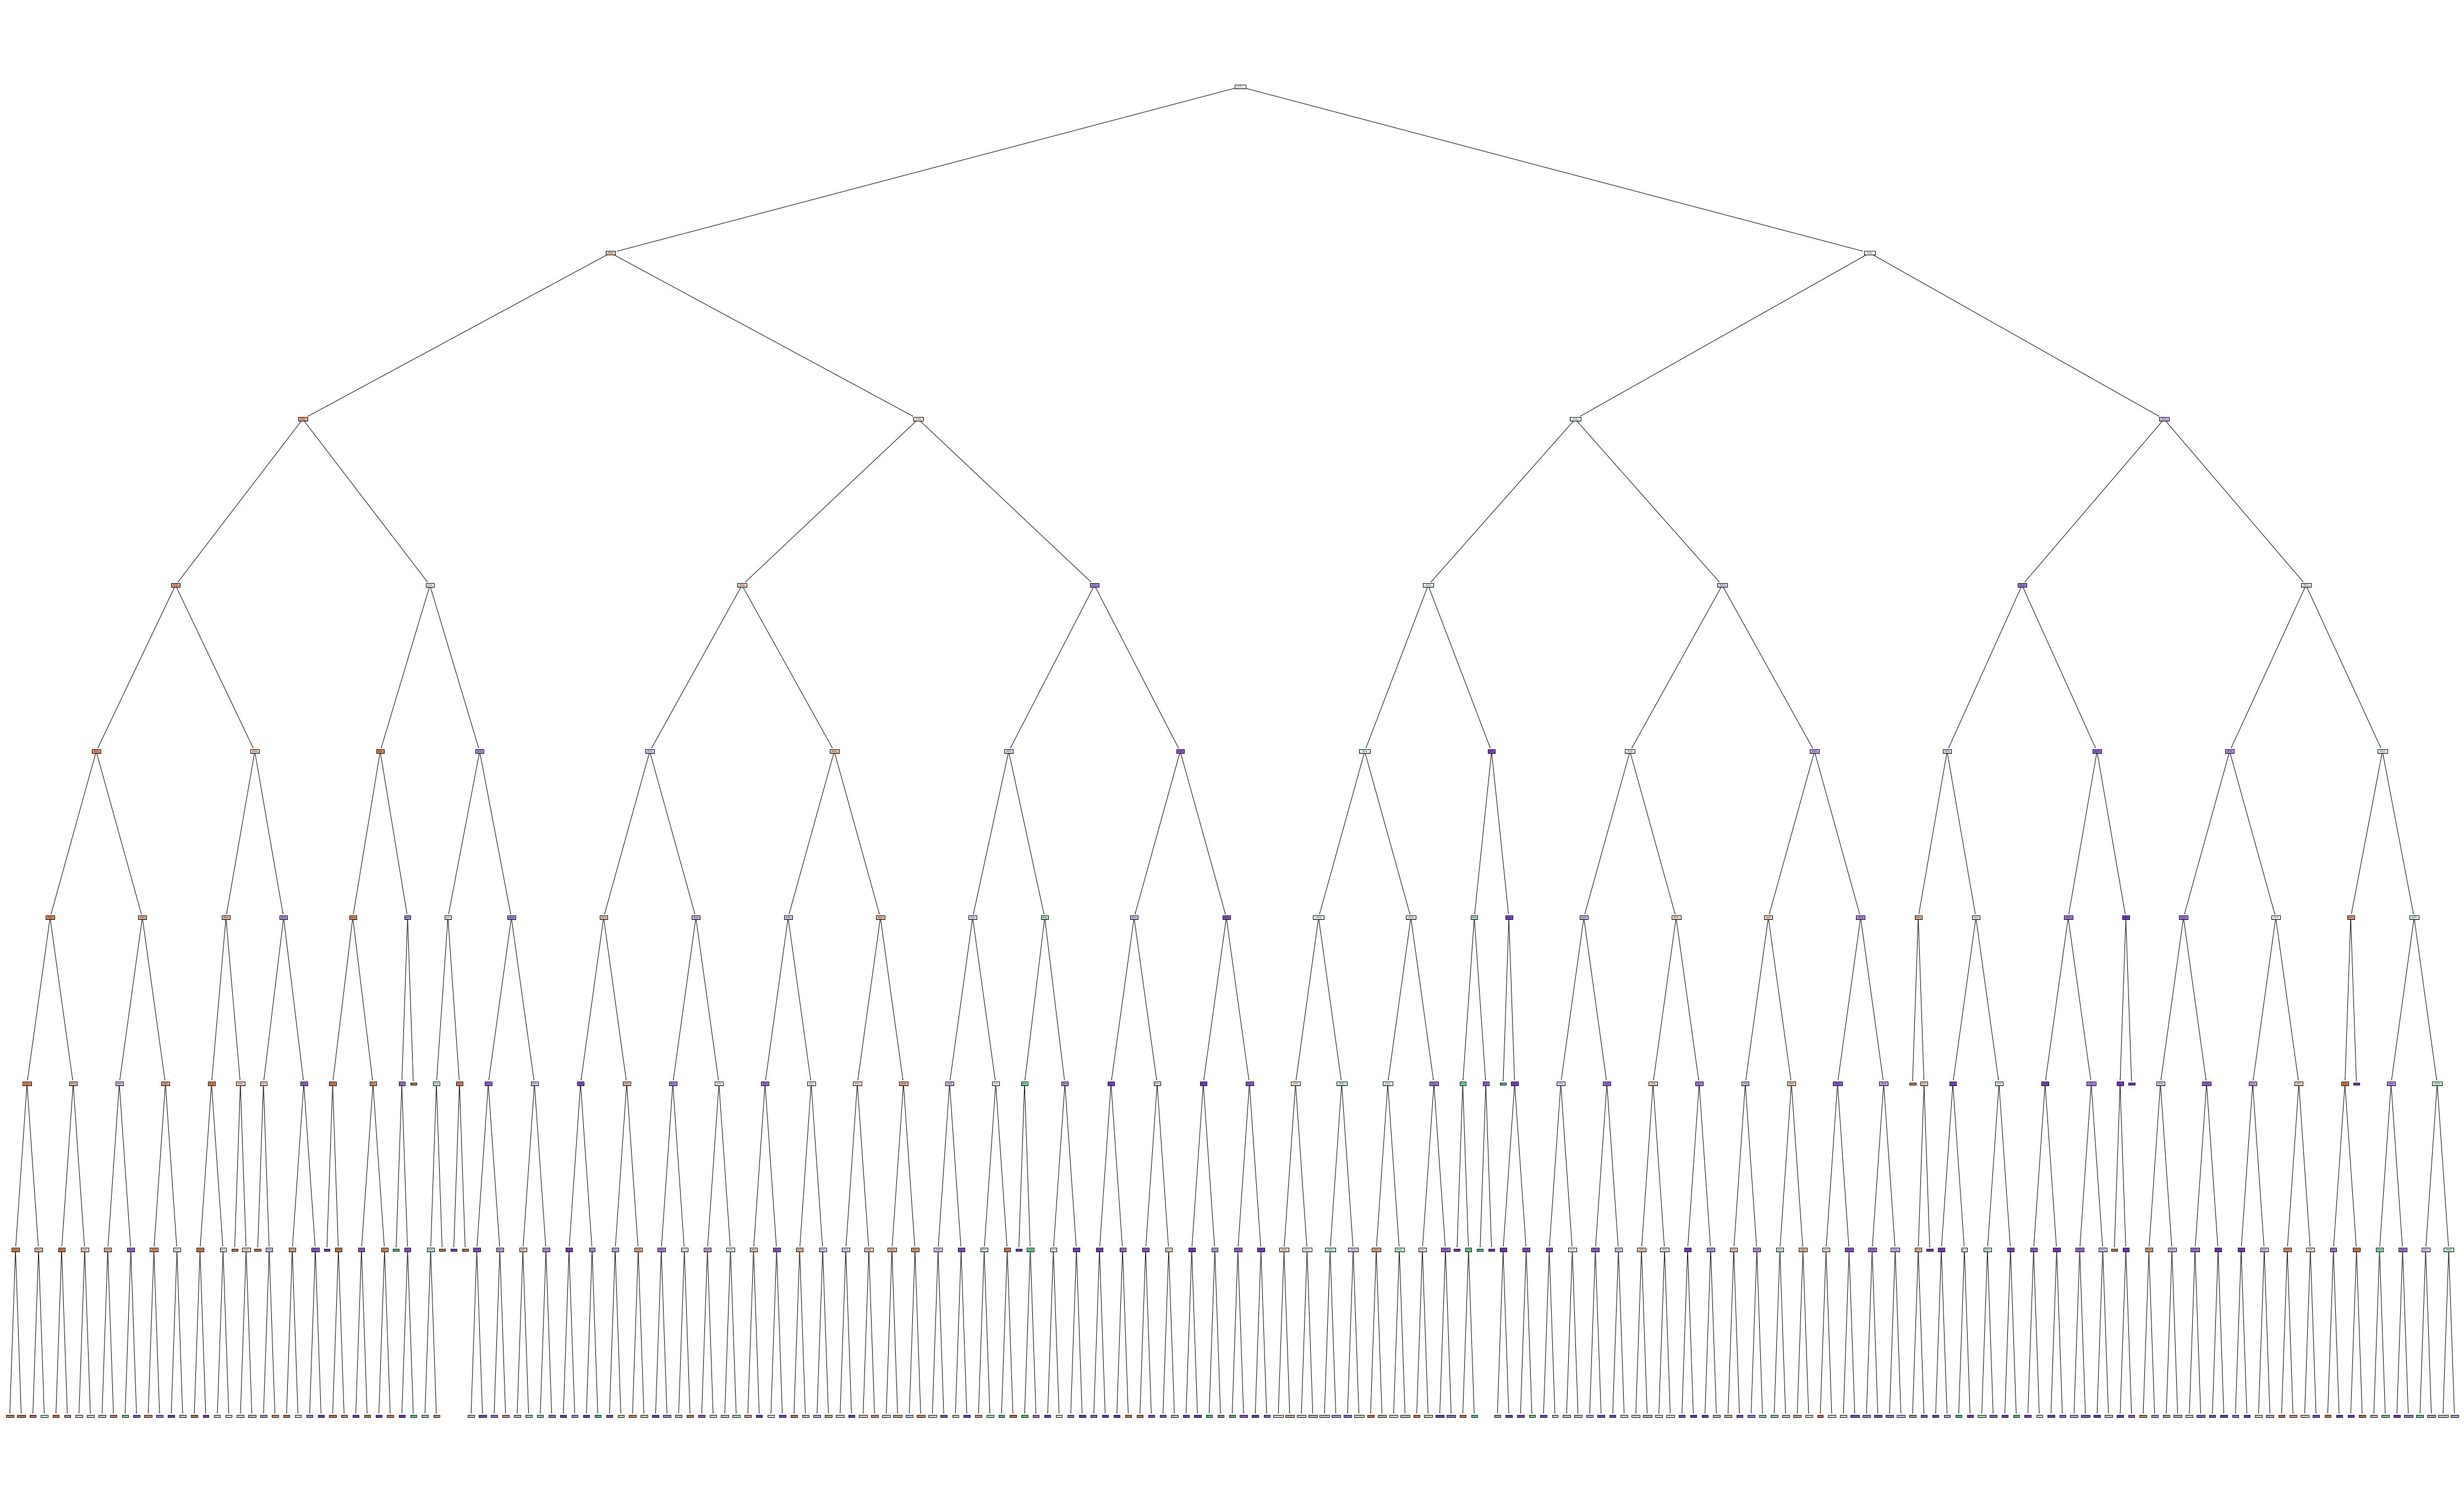

In [14]:
plt.figure(figsize=(80,50))
_ = tree.plot_tree(estimator.best_estimator_, filled=True)

Kako ni ovo nije poboljšalo moć modela, možemo da probamo i ansambl pristup, tj da koristimo šumu.

In [15]:
forest = RandomForestClassifier(n_estimators=5)
forest.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=5)

In [16]:
report(forest, X_test, y_test, "test")

Klasifikacioni izveštaj za model RandomForestClassifier za test podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.62      0.75      0.68      3341
           0       0.27      0.40      0.32      1295
           1       0.91      0.77      0.83      8876

    accuracy                           0.73     13512
   macro avg       0.60      0.64      0.61     13512
weighted avg       0.77      0.73      0.75     13512

---------------------------------------------------------------------------------
Matrica konfuzije za model RandomForestClassifierza test podatke
---------------------------------------------------------------------------------
       0    1    -1
0   2501  452   388
1    464  517   314
-1  1086  937  6853
---------------------------------------------------------------------------------


Vidimo da 5 drveta nije poboljšalo kvalitet modela, pa možemo da pokušamo da povećamo broj njih. 

In [17]:
forest = RandomForestClassifier(n_estimators=500, random_state=42)
forest.fit(X_train, y_train)
report(forest, X_train, y_train)
report(forest, X_test, y_test, "test")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Klasifikacioni izveštaj za model RandomForestClassifier za trening podatke
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

          -1       0.99      0.96      0.97     35597
           0       0.96      0.99      0.97     35597
           1       1.00      1.00      1.00     35597

    accuracy                           0.98    106791
   macro avg       0.98      0.98      0.98    106791
weighted avg       0.98      0.98      0.98    106791

---------------------------------------------------------------------------------
Matrica konfuzije za model RandomForestClassifierza trening podatke
---------------------------------------------------------------------------------
        0      1     -1
0   34216   1381      0
1     493  35104      0
-1      0      0  35597
---------------------------------------------------------------------------------
Klasifikacioni izveštaj za model RandomForestClassif

Kada koristimo 500 drveta, preciznost modela postaje prihvatljiva, ali po cenu interpretabilnosti i vizualizacije.

In [54]:
def auc_score_ovr(y_test, y_pred, c):
    roc_auc_ovr = {}
    # Gets the class
    y_test_array = y_test['Class'].values

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test_array]
    df_aux['pred'] = y_pred
    df_aux = df_aux.reset_index(drop = True)

    tpr, fpr, _ = roc_curve(df_aux['class'], df_aux['pred'])

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['pred']) 
    avg_roc_auc = 0  
    i = 0  
    for k in roc_auc_ovr:  
        avg_roc_auc += roc_auc_ovr[k]  
        i += 1  
    return avg_roc_auc/i, tpr, fpr 
    

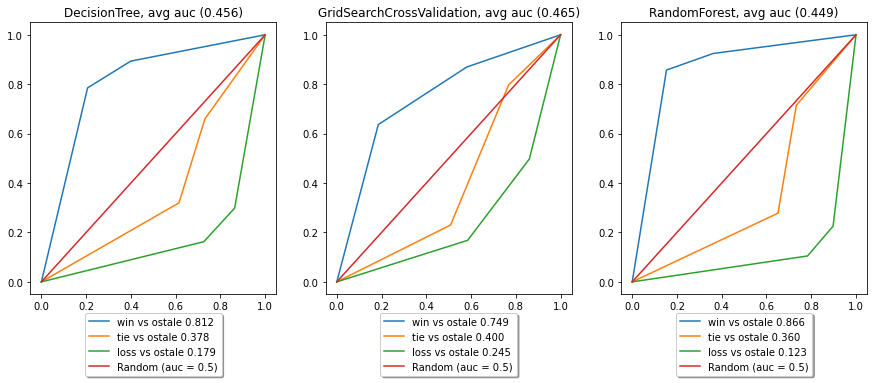

In [68]:
models = [clf, estimator.best_estimator_, forest]
names = ['DecisionTree', 'GridSearchCrossValidation', 'RandomForest']
classes = [(1, 'win'), (0, 'tie'), (-1, 'loss')]
comb = zip(models, names)
fig, plots = plt.subplots(1, 3, layout=None,figsize=(15, 5))
i = 0
for model, name in comb:
    y_pred = model.predict(X_test)
#     falsePR, truePR, _ = roc_curve(y_test, y_pred, pos_label=1)
    auc_sum = 0
    for c, n in classes:
        auc, falsePR, truePR = auc_score_ovr(y_test, y_pred, c)
        auc_sum += auc
        label = f'{n} vs ostale {auc:.3f}' 
        plots[i].plot(falsePR, truePR, label=label)
    plots[i].plot([0,1], [0,1], label='Random (auc = 0.5)')
    plots[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)
    plots[i].set_title(f'{name}, avg auc ({auc_sum/3:.3f})')
    i += 1

Vidimo da Grid Searc CV ima najbolje rezultate u proseku, ali 